Research Question:
- Are interpretable Kickstarter success prediction models equally accurate across categories? 
- Are models trained within specific categories more predictive within their category than models that are trained generally?⭐

# LOAD

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import re
import pandas as pd
from src.utils import load_raw_data, load_processed_data, parse_json_feature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [8]:
kickstarter: pd.DataFrame = load_raw_data(verbose = True, use_relative = True)
kickstarter_toy = load_raw_data(partial = True, use_relative = True)

83 FILES LOADED | TOTAL ROWS: 262892


# PREPROCESSING

0. [Feature Descriptions](#feature-descriptions)
1. [Data Integrity Analysis](#data-integrity-analysis)
    - [Duplication Analysis](#duplication-analysis)
    - [Missingness Analysis](#missingness-analysis)
2. [Data Filtering, Leakage Prevention, and Feature Relevance Assessment](#data-filtering-leakage-prevention-and-feature-relevance-assessment)
3. [Feature engineering](#feature-engineering)

### Feature Descriptions

In [3]:
kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262892 entries, 0 to 262891
Data columns (total 42 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   backers_count                       262892 non-null  int64  
 1   blurb                               262811 non-null  object 
 2   category                            262892 non-null  object 
 3   converted_pledged_amount            245625 non-null  float64
 4   country                             262892 non-null  object 
 5   country_displayable_name            262892 non-null  object 
 6   created_at                          262892 non-null  int64  
 7   creator                             262892 non-null  object 
 8   currency                            262892 non-null  object 
 9   currency_symbol                     262892 non-null  object 
 10  currency_trailing_code              262892 non-null  bool   
 11  current_currency          

Grouped generally by meaning:

**Identifiers & Text**
- `id`: internal project ID
- `name`: project title
- `blurb`: short description

**URLs & Media**
- `slug`: URL slug of the project
- `source_url`: The category url
- `urls`: dictionary with urls pertaining to that project. The project front page, the rewards page, etc.
- `photo`: dictionary with urls to the photos used in the banner, thumbnail etc.  
- `video`: dictionary with video information  

**Creator & Project Profile Information**
- `creator`: dictionary with creator information  
  - name, is_registered, is_email_verified, chosen_currency, is_superbacker, has_admin_message_badge, ppo_has_action, backing_action_count, avatar (image urls)
- `profile`: dictionary with some redundant project page text information, and some page styling information
- `category`: dictionary with categorical information about the campaign
  - name, analytics_name, slug, position, parent_name, and some page information  

**Geographic Details**
- `country`: 2 letter country abbreviation  
- `country_displayable_name`: human-readable country name  
- `location`: dictionary with location information  
  - 'id', 'name', 'slug', 'short_name', 'displayable_name', 'localized_name', 'country', 'state', 'type', 'is_root', 'expanded_country', 'urls'  


**Goals & Currency**
- `goal`: funding goal in the project's currency  
- `currency`: original currency code  
- `currency_symbol`: the display symbol for currency  
- `currency_trailing_code`: whether symbol / code trails the number (BOOL)  

**Exchange Rates**
- `fx_rate`: snapshot FX rate (original currency to USD)  
- `static_usd_rate`: platform's "static" USD rate  
- `usd_exchange_rate`: FX used for pledged -> USD at update time  
- `usd_type`: how USD conversion was computed  

**Funding & Performance**
- `backers_count`: number of backers (count)  
- `pledged`: amount pledged in original currency  
- `converted_pledged_amount`: pledged converted to USD  
- `usd_pledged`: pledged in USD  
- `percent_funded`: 100 * pledged / goal  

**Timestamps**
- `created_at`: date the project was first drafted  
- `launched_at`: project's actual launch date (went live)  
- `deadline`: scheduled ending time  
- `state_changed_at`: date the projecct's status was last changed  

**Launch & Visibility**
- `is_launched`: whether the project was launched  
- `prelaunch_activated`: whether a "coming soon" page was used  
- `staff_pick`: a staff-curated badge  
- `spotlight`: specially highlighted page  

**Interaction & Moderation**
- `disable_communication`: whether comments / updates are disabled  
- `is_starrable`: whether users can "star" it  
- `is_liked`, `is_disliked`: viewer specific liked or disliked (all False here)  
- `is_in_post_campaign_pledging_phase`: whether the campaign finished and is in its pledge fulfilling phase (only for successful)  

**Target**
- `state`: project status string. Can be:  
  - successful - reached goal by deadline (positive class)  
  - failed - did not reach goal by deadline (negative class)  
  - submitted - submitted for review by Kickstarter staff but not yet live  
  - live - project is currently active and accepting pledges  
  - canceled - creator canceled before deadline  
  - suspended - Kickstarter suspended (ToS)  


### Data Integrity Analysis

#### Duplication Analysis

From a base `.duplicated().sum()` count, we observe very few "true duplicated rows":

In [93]:
print("True duplicated rows: ", kickstarter.duplicated().sum())

True duplicated rows:  12


However, examining duplication only considering unique `id`:

In [94]:
print("Duplicate ids: ", kickstarter['id'].duplicated().sum())

Duplicate ids:  57362


It's clear true duplication is not the full picture.
- We have only 12 truly duplicate rows
- But we have 57362 duplicate ids

Something doesn't add up. Its likely that this scrape contains multiple snapshots per project. Since we do not have a column which indicates "most updated" row, we must make a few judgement calls.

First, we want to analyze which columns are likely the "update" column that is causing our true duplication to be so low:

In [95]:
id_column_pair_duplication = []
for column in kickstarter.columns:
    if column != 'id':
        duplication_count = kickstarter[['id', column]].duplicated().sum()
        id_column_pair_duplication.append({
            'id_feature_pair': column,
            'duplication_count': duplication_count
        })
id_column_pair_duplication = pd.DataFrame(id_column_pair_duplication)
display(id_column_pair_duplication.sort_values(by = 'duplication_count'))

,id_feature_pair,duplication_count
7,creator,14
30,source_url,1747
22,location,43834
14,fx_rate,48054
3,converted_pledged_amount,56379
37,usd_exchange_rate,56439
40,video,56455
38,usd_pledged,56946
26,pledged,56960
24,percent_funded,56960


Overwhelmingly, it seems to be the fault of the `creator` feature.
- At some time during a campaign's lifetime, the creator might be actively changing their information, their username, profile picture, whether they are verified, etc.
- The minute changes were then counted as separate in the scrape.

Unfortunately, this does not narrow down how best to choose amongst the duplicate `id` rows.
- Within `creator` there is no timestamp information for when this feature was changed.

Trying to narrow down how best to choose amongst the other features also has varying issues:
- Most features don't have recency built in. For example: though `location` with `id` has substatially lower duplicates, we cannot differentiate which to keep based on location, since we do not know the true final location.
- Most features will not eliminate many duplicates. For example: picking by most backers seems like a reasonable judgement, but this will maximally only eliminate a couple hundred duplicates.

For these reasons, we will make the following judgement calls to address duplication:
1. Eliminate true duplicates (easily safe)
2. Narrow down duplicates based on most backers (will eliminate a couple hundred)
3. Drop the rest of the duplicates by `id`

The final drop can be reasoned with the following - because the duplicates are already so similar in the most important factors beside creator, keeping duplicates at random with a final drop is as reasonable as we can afford.

In [3]:
def apply_deduplication_steps(kickstarter) -> pd.DataFrame:
    kick_nodup = kickstarter.copy()
    print(f"Number of rows before deduplication: {kick_nodup.__len__()}")
    # Eliminate true duplicates
    kick_nodup = kick_nodup.drop_duplicates()

    # Narrow down by most backers (built in recency)
    max_per_id = kick_nodup.groupby("id")["backers_count"].transform("max") # Group rows by id, get backers_count
                                                                            # transform("max") gives us a series 1:1 with original except filling each row with the group max
    kick_nodup = kick_nodup[kick_nodup["backers_count"] == max_per_id]

    # Drop the rest of the duplicates by `id`
    kick_nodup = kick_nodup.drop_duplicates(subset=['id']).reset_index()
    print(f"Number of rows after applying deduplication steps: {kick_nodup.__len__()}")
    
    return kick_nodup
kick_nodup = apply_deduplication_steps(kickstarter)

Number of rows before deduplication: 262892
Number of rows after applying deduplication steps: 205530


#### Missingness Analysis

First examining the missingness of the set after deduplication

PERCENTAGE MISSING
blurb                                  0.018489
usd_type                               0.030652
location                               0.121637
converted_pledged_amount               3.818421
usd_pledged                            3.818421
usd_exchange_rate                      3.818421
video                                 35.736389
is_in_post_campaign_pledging_phase    73.960006
dtype: float64


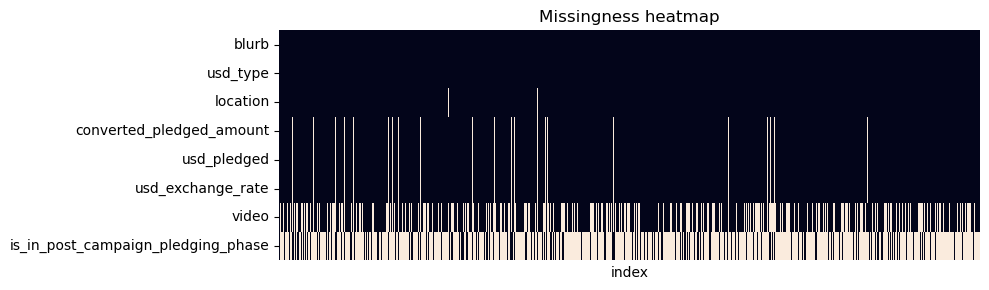

In [8]:
nulls = kick_nodup.isnull().sum(axis = 0)
nulls = nulls[nulls > 0].sort_values(ascending=True) # Filtering for columns that actually have at least 1 missing value

print("PERCENTAGE MISSING")
print(nulls / kick_nodup.__len__() * 100)

mask = kick_nodup.isnull()
mask = mask[nulls.index]
mat = mask.T

plt.figure(figsize = (10, 3))
ax = sns.heatmap(
    mat.astype(int),
    cbar = False,
    linewidths = 0,
    xticklabels = False
)
ax.set_xlabel("index")
ax.set_title("Missingness heatmap")
plt.tight_layout()
plt.show()

We have just only a few missing values for `blurb`, `usd_type` and `location`
- All three only have a couple hundredths of a percent missing.

We have slighly higher missingness in `converted_pledged_amount`, `usd_pledged` and `usd_exchange_rate`:
- All three have exactly the same missingness, at 3.82% missingness
- Furthermore, they seem to be conjointly missing, meaning if one is missing, the other two are also always missing

Lastly we have highest missinging in `video` and `is_in_post_campaign_pledging_phase`:
- `video` having 35.74% missingness and `is_in_post_campaign_pledging_phase` having 73.96% missingness.

---

**Examining features closer to inform imputation:**

For `blurb`:
- Since `blurb` is unique to each particular campaign, it is inappropriate to impute this with anything we can assume from other data points
    - We will assume the blurb will be similar in content to the title, and impute by project name.

In [4]:
def impute_blurb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['blurb'] = df['blurb'].fillna(df['name'])
    return df

For `usd_type`:

In [10]:
# Examining usd_type
usd_type_mode = kickstarter["usd_type"].mode()[0]
print(
    f"Percentage of 'usd_type' that is {usd_type_mode}: {(
        (kickstarter["usd_type"] == usd_type_mode).sum()
        / kickstarter.__len__()
        * 100
    )}%"
)

Percentage of 'usd_type' that is domestic: 99.9269662066552%


Reasonable to impute by mode, given that the dataset is overwhelming one mode.

In [5]:
def impute_usd_type(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["usd_type"] = df["usd_type"].fillna(df["usd_type"].mode()[0])
    return df

---

For `location`

In [ ]:
# Examining location
parse_json_feature(kickstarter['location'][0])

{'id': 44418,
 'name': 'London',
 'slug': 'london-gb',
 'short_name': 'London, UK',
 'displayable_name': 'London, UK',
 'localized_name': 'London',
 'country': 'GB',
 'state': 'England',
 'type': 'Town',
 'is_root': False,
 'expanded_country': 'United Kingdom',
 'urls': {'web': {'discover': 'https://www.kickstarter.com/discover/places/london-gb',
   'location': 'https://www.kickstarter.com/locations/london-gb'},
  'api': {'nearby_projects': 'https://api.kickstarter.com/v1/discover?signature=1757604986.29d3e3985af91871c322a99e8bdbb47f0d7ec263&woe_id=44418'}}}

We can see several potentially useful data fields within `location`. Namely:
- `name`, which seems to be city name.
- `state`, which seems to be state name.
- `type`, which seems to indicate the type of location.

In [13]:
# Examining distributions for location

locations_not_null = kickstarter[kickstarter['location'].notnull()]['location'].apply(parse_json_feature)
location_cols = locations_not_null.apply(
    lambda d: pd.Series({
        'loc_name': d.get('name'),
        'loc_state': d.get('state'),
        'loc_type': d.get('type'),
    })
)
location_cols.describe()


,loc_name,loc_state,loc_type
count,262495,262423,262495
unique,14130,1221,9
top,London,CA,Town
freq,11216,28529,244120


Location information seems to follow a heavy right skewed distribution. For type in particular, town seems to be overwhelmingly common. For state and name, the skew is not sharp enough to assume any particularly overwhelmingly common singular value.
- For all three: we cannot impute by most common and expect a probable correctness of our fit.

We will impute by mode of the missing value grouped by country. So, if a city name is missing from the US, for example, the state, city and town would be imputed as CA, Los Angeles, Town.

Lastly, we will discard `location` column, as all relevant information has already been extracted from it.

In [7]:
# "Impute" + engineering. We are engineering new features then imputing those features
def impute_location(df: pd.DataFrame) -> pd.DataFrame:
    def parse_json_feature(raw):
        return json.loads(raw)
    locations_not_null = df[df['location'].notnull()]['location'].apply(parse_json_feature)
    location_cols = locations_not_null.apply(
        lambda d: pd.Series({
            'loc_name': d.get('name'),
            'loc_state': d.get('state'),
            'loc_type': d.get('type'),
        })
    )

    df = df.join(location_cols, how='left')

    mode_loc_name_by_country = (
        df.loc[df["loc_name"].notnull()]
        .groupby("country")["loc_name"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    df["loc_name"] = df["loc_name"].fillna(df["country"].map(mode_loc_name_by_country))

    mode_loc_state_by_country = (
        df.loc[df["loc_state"].notnull()]
        .groupby("country")["loc_state"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    df["loc_state"] = df["loc_state"].fillna(df["country"].map(mode_loc_state_by_country))

    mode_loc_type_by_country = (
        df.loc[df["loc_type"].notnull()]
        .groupby("country")["loc_type"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    df["loc_type"] = df["loc_type"].fillna(df["country"].map(mode_loc_type_by_country))

    df = df.drop(columns = ['location'])
    return df

---

For `usd_pledged`, `converted_pledged_amount` and `usd_exchange_rate`

- $\text{usd\_pledged} = \text{pledged} \times \text{static\_usd\_rate}$. 
    - Since neither of those are missing when `usd_pledged` is missing, we will simply fill in the missing portion by formula.
- $\text{converted\_pledged\_amount} = \lfloor \text{pledged} \times \text{usd\_exchange\_rate} \rfloor$.
    - We will use the non missing `currency` featuer to impute missing `usd_exchange_rate`, then use that to impute the missing `converted_pledged_amount` by formula.
    - Because `usd_exchange_rate` for each currency changes for each observation (the exchange rate changes over time), we will impute this based on the mean of the currency's exchange rate.

In [8]:
def impute_money_features(df: pd.DataFrame) -> pd.DataFrame:
    # Impute usd_pledged
    df['usd_pledged'] = df['usd_pledged'].fillna(df['pledged'] * df['static_usd_rate'])

    # Impute usd_exchange_rate
    mean_usd_exchange_rate_by_currency = df.groupby(by = 'currency')['usd_exchange_rate'].mean()
    df['usd_exchange_rate'] = df['usd_exchange_rate'].fillna(df['currency'].map(mean_usd_exchange_rate_by_currency))

    # Impute converted_pledged_amount
    df['converted_pledged_amount'] = df['converted_pledged_amount'].fillna(df['pledged'] * df['usd_exchange_rate'])
    return df

---

For `video`
- No imputation, instead converting `video` into an indicator variable later during feature engineering. We don't intend to deal with video data, but since we have sufficient missingness, we can use the missingness itself as a predictor.

In [10]:
# This is closer to transformation than imputation, but for our purpose, it is transformation in service to imputate
def impute_video(df: pd.DataFrame) -> pd.DataFrame:
    df['has_video'] = df['video'].notnull()
    df = df.drop(columns = ['video'])
    return df

---
For `is_in_post_campaign_pledging_phase`
- An indicator variable for whether a project is already successful and currently fulfilling pledges. This feature has high missingness at nearly 74% missing.
    - Both for data leakage prevention and for the fact of high missingness, the column is simply dropped.

In [11]:
def impute_is_in_post_campaign_pledging_phase(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns = ['is_in_post_campaign_pledging_phase'])
    return df

---

Applying missingness strategies:

In [12]:
def apply_missingness_handling(df: pd.DataFrame) -> pd.DataFrame:
    df = impute_blurb(df)
    df = impute_usd_type(df)
    df = impute_location(df)
    df = impute_money_features(df)
    df = impute_video(df)
    df = impute_is_in_post_campaign_pledging_phase(df)
    return df
kick_clean = apply_missingness_handling(kick_nodup)

In [20]:
kick_clean.isnull().sum()

index                       0
backers_count               0
blurb                       0
category                    0
converted_pledged_amount    0
country                     0
country_displayable_name    0
created_at                  0
creator                     0
currency                    0
currency_symbol             0
currency_trailing_code      0
current_currency            0
deadline                    0
disable_communication       0
fx_rate                     0
goal                        0
id                          0
is_disliked                 0
is_launched                 0
is_liked                    0
is_starrable                0
launched_at                 0
name                        0
percent_funded              0
photo                       0
pledged                     0
prelaunch_activated         0
profile                     0
slug                        0
source_url                  0
spotlight                   0
staff_pick                  0
state     

### Data Filtering, Leakage Prevention, and Feature Relevance Assessment

**Filtering for final outcome**

Because we are interested in supervised modeling, we will only keep projects with finalized outcomes. Meaning projects either **successful**, or **failed** final `state`.

In [13]:
# Keep only final outcome states
def keep_only_final_outcome_states(df: pd.DataFrame):
    df = df[df['state'].isin(['successful', 'failed'])].copy()
    return df

**Leakage Prevention**

Data leakage features are those that contain information unavailable at the time of prediction (e.g., after campaign launch or after campaign ends).

| Column                                               | Why it leaks                                              |
| ---------------------------------------------------- | --------------------------------------------------------- |
| `backers_count`                                      | Number of backers is directly correlated to the pledged amount.                        |
| `pledged`, `usd_pledged`, `converted_pledged_amount` | Contain the actual outcome.                               |
| `percent_funded`                                     | Directly derived from `pledged / goal`.                   |
| `usd_exchange_rate`                                  | Calculated after pledges are received.                    |
| `state_changed_at`                                   | Timestamp of final outcome.                               |
| `spotlight`                                          | Spotlight is always true for successfully funded projects (all funded projects gain access to spotlighting tools).                       |
| `is_in_post_campaign_pledging_phase`                 | Only exists post-outcome.                                 |

In [14]:
def drop_leakage_columns(df: pd.DataFrame) -> pd.DataFrame:
    leakage_columns = [
        "backers_count",
        "pledged",
        "usd_pledged",
        "converted_pledged_amount",
        "percent_funded",
        "usd_exchange_rate",
        "state_changed_at",
        "spotlight",
        # "is_in_post_campaign_pledging_phase", # Already removed by missingness handling
    ]

    df = df.drop(columns=leakage_columns)
    return df

**Irrelevant or Redundant Features**

Features that do not describe the campaign meaningfully or are purely metadata / UI-oriented.

| Column                                                          | Reason                                                                              |
| --------------------------------------------------------------- | ----------------------------------------------------------------------------------- |
| `id`, `slug`, `source_url`, `urls`                              | Internal or web-identifiers.                                                        |
| `currency_symbol`, `currency_trailing_code`, `current_currency` | Formatting/UI attributes.                                                           |
| `is_liked`, `is_disliked`, `is_starrable`                       | Viewer-specific or static fields. These are all either false or true for this scrape.                                                |
| `country_displayable_name`                                      | Redundant with `country`.                                                           |


In [15]:
def drop_irrelevant_columns(df: pd.DataFrame) -> pd.DataFrame:
    irrelevant_columns = [
        "id",
        "slug",
        "source_url",
        "urls",
        "currency_symbol",
        "currency_trailing_code",
        "current_currency",
        "is_liked",
        "is_disliked",
        "is_starrable",
        "country_displayable_name",
    ]

    df = df.drop(columns = irrelevant_columns)
    return df

**Complex nested JSON feature relevance analysis**

Many features are nested dictionaries of further features. Most of the nested dictionary contains information that may not be used, but further examination is necessary to determine exactly what information to retain. `photo`, `creator`, and `profile` in particular do not seem to hold relevant information, but further analysis is needed to be sure.

For `photo`
- Our analysis will not directly deal with complex image data. This column has no direct missingness, but since the object is nested, we need to perform analysis on whether the object is truly not missing for all rows. This will inform whether an indicator variable should be considered, or the column should simply be dropped.

In [116]:
# Checking missingness of image (per scrape observation)
num_photo_missing = kick_clean['photo'].isnull().sum()
print(f"Number of missing videos = {num_photo_missing} \
      Percentage: {num_photo_missing / kick_clean.__len__() * 100:.2f}%")

# Checking if every campaign has an image present in their photo json object
photos = kick_clean["photo"].apply(json.loads)
some_missing_full_image = photos.apply(lambda x: pd.isnull(x.get("full"))).any()
print("Photo status:")
if some_missing_full_image:
    print("\tPhoto missing for some campaign(s)! Consider indicator variable")
else:
    print("\tEvery campaign has a photo! Consider dropping photo")

Number of missing videos = 0       Percentage: 0.00%
Photo status:
	Every campaign has a photo! Consider dropping photo


Since every single campaign in our list has an image, an indicator variable would not be informative.

In [16]:
def drop_photo(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns = ['photo'])
    return df

---

For `creator`:
- This variable is rather difficult to parse, since there are so many extra inner quotes present that are unescaped.

In [27]:
def parse_kickstarter_creator(raw):
    raw = raw.replace('\t', '\\t').replace('\n', '\\n').replace('\r', '\\r')
    # fix name: remove extra inner quotes in the name value
    key_start = '"name":"'
    i = raw.find(key_start)
    if i != -1:
        name_start = i + len(key_start)
        j = raw.find('","', name_start)  # end of the name string
        if j != -1:
            name_val = raw[name_start:j]
            name_fixed = name_val.replace('"', '')  # strip stray inner quotes
            raw = raw[:name_start] + name_fixed + raw[j:]

    # I can catch most of the problems with the simple above fix, but there are a few that are
    # simply not worth the trouble to fully catch
    try:
        return json.loads(raw)
    except Exception:
        print("EXCEPTION: ", raw)
        return np.nan

creators = kick_clean['creator'].apply(parse_kickstarter_creator)

total_not_null = 0
for creator in creators:
    if type(creator) is float:
        continue
    if pd.notnull(creator['is_email_verified']) or pd.notnull(creator['is_registered']) or pd.notnull(creator['is_superbacker']):
        total_not_null += 1
print("Total not null relevant features: ", total_not_null)

EXCEPTION:  {"id":860665384,"name":"//DoloMcCombKimberlyLesikScottStafford\\\","slug":"cathedralcollective","is_registered":null,"is_email_verified":null,"chosen_currency":null,"is_superbacker":null,"has_admin_message_badge":false,"ppo_has_action":false,"backing_action_count":0,"avatar":{"thumb":"https://i.kickstarter.com/assets/010/849/136/eb10895768e7303de07eeccbfad69581_original.png?anim=false&fit=cover&height=40&origin=ugc&q=92&v=1461716176&width=40&sig=751vXIb%2FFwhKjKv7vIvtx5bgS7HL5Pf%2B1gpiihWiyo0%3D","small":"https://i.kickstarter.com/assets/010/849/136/eb10895768e7303de07eeccbfad69581_original.png?anim=false&fit=cover&height=80&origin=ugc&q=92&v=1461716176&width=80&sig=14iCZVvR3QuSni9vqP7dBpKcYE4rXZYVmTooPU6nk6M%3D","medium":"https://i.kickstarter.com/assets/010/849/136/eb10895768e7303de07eeccbfad69581_original.png?anim=false&fit=cover&height=160&origin=ugc&q=92&v=1461716176&width=160&sig=JbMG%2BdjEr5aceHdY3d9hzdl08DcPvEifDZvbuy2fYy8%3D"},"urls":{"web":{"user":"https://www.kic

- This variable contains some various information like name, avatar, whether they are registered or email verified, etc.
- Unfortunately, it seems that boolean information, like whether they are registered or not, is fully missing from this variable, so there is nothing useful for us to extract.
- We may consider further analysis with this variable later (for example, analysis on whether creator's have more success if they have had experience with other kickstarter projects), but for now we deem it irrelevant.

In [17]:
def drop_creator(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns = ['creator']).copy()
    return df

---

For `profile`

In [31]:
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
kick_clean['profile'].tail(10).apply(parse_json_feature).values

array([{'id': 5147669, 'project_id': 5147669, 'state': 'inactive', 'state_changed_at': 1741876381, 'name': None, 'blurb': None, 'background_color': None, 'text_color': None, 'link_background_color': None, 'link_text_color': None, 'link_text': None, 'link_url': None, 'show_feature_image': False, 'background_image_opacity': 0.8, 'should_show_feature_image_section': True, 'feature_image_attributes': {'image_urls': {'default': 'https://i.kickstarter.com/assets/048/916/785/1fba81a7ac46229cdc131eace41a5465_original.png?anim=false&fit=cover&gravity=auto&height=873&origin=ugc&q=92&v=1744730309&width=1552&sig=bbyMQEcWKoq5l5e7jKVIdcWmXvwpZ4iRZbrRM3AVG18%3D', 'baseball_card': 'https://i.kickstarter.com/assets/048/916/785/1fba81a7ac46229cdc131eace41a5465_original.png?anim=false&fit=cover&gravity=auto&height=315&origin=ugc&q=92&v=1744730309&width=560&sig=88lxl3H%2BK0BCNAXL8%2FDXzOTfoRdIhDLaJ18BT0gMEwE%3D'}}},
       {'id': 5060640, 'project_id': 5060640, 'state': 'inactive', 'state_changed_at': 173


- Contains redundant text information (like title and blurb), and upon further examination, the extra page styling information is fully missing from this variable. Because of this, this is deemed not useful to extract and redundant.

In [18]:
def drop_profile(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns = ['profile'])
    return df

---

Applying data filtering for leakage prevention and feature relevance

In [19]:
def apply_data_filtering_steps(df: pd.DataFrame) -> pd.DataFrame:
    df = keep_only_final_outcome_states(df)
    df = drop_leakage_columns(df)
    df = drop_irrelevant_columns(df)
    df = drop_photo(df)
    df = drop_creator(df)
    df = drop_profile(df)
    return df
kick_clean = apply_data_filtering_steps(kick_clean)

In [34]:
kick_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 0 to 205528
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  185950 non-null  int64  
 1   blurb                  185950 non-null  object 
 2   category               185950 non-null  object 
 3   country                185950 non-null  object 
 4   created_at             185950 non-null  int64  
 5   currency               185950 non-null  object 
 6   deadline               185950 non-null  int64  
 7   disable_communication  185950 non-null  bool   
 8   fx_rate                185950 non-null  float64
 9   goal                   185950 non-null  float64
 10  is_launched            185950 non-null  bool   
 11  launched_at            185950 non-null  int64  
 12  name                   185950 non-null  object 
 13  prelaunch_activated    185950 non-null  bool   
 14  staff_pick             185950 non-null  b

### Feature Engineering

Here we will address further features that may be relevant, but are currently unusuable in our future modeling. We need to:
- Parse the remaining JSON features and extract relevant info
- Convert text data into usable forms
- Convert timestamp features into usable datetime form


For `category`:
- `category` is be a relevant feature, but it is, like many other features, in string literal JSON dictionary form and is unsuable in the current state.

In [50]:
categories = kick_clean['category'].apply(parse_json_feature)
categories[0]

{'id': 284,
 'name': 'Musical',
 'analytics_name': 'Musical',
 'slug': 'theater/musical',
 'position': 5,
 'parent_id': 17,
 'parent_name': 'Theater',
 'color': 16743775,
 'urls': {'web': {'discover': 'http://www.kickstarter.com/discover/categories/theater/musical'}}}

From a sample of the data, we can see three potentially relevant columns:
- `name`: the name of the category (this is the subcategory name, every category has a parent category)
- `position`: the "listing position" of the project in the category at the time of the snapshot.
- `parent_name`: the name of the parent category.

We will extract these columns and drop the original unusuable dictionary column

In [20]:
def extract_categories(df: pd.DataFrame) -> pd.DataFrame:
    categories = df['category'].apply(parse_json_feature)
    df['cat_name'] = categories.apply(lambda x: x.get('name'))
    df['cat_position'] = categories.apply(lambda x: x.get('position'))
    df['cat_parent_name'] = categories.apply(lambda x: x.get('parent_name'))
    df = df.drop(columns = ['category'])
    return df

---
For text features `blurb` and `name`
- We are not planning to use embeddings. Instead, we will extract some very simple metrics from this text and use it as a predictor.
    - For now, we will only be using the length of the text as a predictor: `blurb_len`  and `name_len`, and the average word length as a predictor: `blurb_avg_word_len` and `name_avg_word_len`

In [21]:
def get_words(text: str) -> list[str]:
    words = re.findall(r"\b\w+\b", text.lower()) # Ignores punctuation
    return words

def get_avg_word_len(text: str) -> float:
    words = get_words(text)
    return (sum(w.__len__() for w in words) / words.__len__()) if words else 0.0

def engineer_text_features(df: pd.DataFrame) -> pd.DataFrame:
    df['blurb_len'] = df['blurb'].apply(lambda x: x.strip().__len__())
    df['name_len'] = df['name'].apply(lambda x: x.strip().__len__())
    df['blurb_avg_word_len'] = df['blurb'].apply(get_avg_word_len)
    df['name_avg_word_len'] = df['name'].apply(get_avg_word_len)
    return df

# test_string = "hello;;; world!"
# get_words(test_string)
# get_avg_word_len(test_string)

---
For timestamp features `created_at`, `deadline` and `launched_at`

In [126]:
kick_clean[['created_at', 'deadline', 'launched_at']].head(5)

,created_at,deadline,launched_at
0,1428084500,1431007264,1428415264
1,1708550474,1712004780,1709215894
2,1422283856,1424942634,1422350634
3,1623651994,1626545708,1623953708
4,1353116690,1356148800,1353954082


These look very much like Unix timestamps, which are seconds since Unix start time of Jan. 1 1970. We can convert these simply using `pd.to_datetime()`

In [22]:
def convert_timestamp_features(df: pd.DataFrame) -> pd.DataFrame:
    df['created_at'] = pd.to_datetime(df['created_at'], unit='s')
    df['deadline'] = pd.to_datetime(df['deadline'], unit='s')
    df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')
    return df

We will additionally engineer another feature, `duration`, which will represent the total duration between `launched_at` and `deadline` that the project ran for.
- It seems reasonable to investigate whether project duration has bearing on project success. After all, intuitively one might think that a longer duration would give more chances for crowdfunding, and therefore push success rate higher.
- We will engineer duration to be in units of days

In [24]:
def engineer_duration(df: pd.DataFrame) -> pd.DataFrame:
    df['duration'] = (df['deadline'] - df['launched_at']).dt.days
    return df

---

Applying feature engineering:

In [25]:
def apply_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = extract_categories(df)
    df = engineer_text_features(df)
    df = convert_timestamp_features(df)
    df = engineer_duration(df)
    return df
kick_clean = apply_feature_engineering(kick_clean)

In [26]:
kick_clean.loc[0]

index                                                                    0
blurb                    Forbear! is a new theatre company aiming to pr...
country                                                                 GB
created_at                                             2015-04-03 18:08:20
currency                                                               GBP
deadline                                               2015-05-07 14:01:04
disable_communication                                                False
fx_rate                                                            1.35329
goal                                                               10000.0
is_launched                                                           True
launched_at                                            2015-04-07 14:01:04
name                                                      Forbear! Theatre
prelaunch_activated                                                  False
staff_pick               

# EDA

1. [Descriptive Statistics](#descriptive-statistics)
2. [Distribution Analysis (Visualizations)](#distribution-analysis-visualizations)
    - [Correlation Analyses](#correlation-analyses)
    - [Univariate Distributions](#univariate-distributions)
    - [Bivariate Distributions](#bivariate-distributions)


### Descriptive Statistics

Some descriptive statistics, separated by variable type

In [27]:
# Numerical descriptive statistics
kick_clean.drop(columns = ['index']).describe()

,created_at,deadline,fx_rate,goal,launched_at,static_usd_rate,cat_position,blurb_len,name_len,blurb_avg_word_len,name_avg_word_len,duration
count,185950,185950,185950.000000,1.859500e+05,185950,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000
mean,2019-03-27 01:00:07.309078016,2019-06-22 07:34:14.048868352,0.987090,5.935131e+04,2019-05-20 01:04:35.748717056,0.985313,7.174203,104.802624,35.259414,4.912005,5.347770,33.060059
min,2009-04-22 02:11:10,2009-05-16 09:59:00,0.006782,1.000000e-02,2009-04-25 15:36:21,0.006209,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,2015-09-13 20:34:37.249999872,2015-12-03 01:21:26.500000,1.000000,1.500000e+03,2015-11-01 16:18:44,1.000000,3.000000,85.000000,22.000000,4.363636,4.400000,29.000000
50%,2018-12-09 16:10:49,2019-03-15 19:22:07,1.000000,5.000000e+03,2019-02-08 16:17:08.500000,1.000000,6.000000,117.000000,35.000000,4.826087,5.125000,30.000000
75%,2023-02-25 01:08:00,2023-06-02 03:59:00,1.000000,1.410000e+04,2023-04-30 13:33:52,1.000000,10.000000,131.000000,49.000000,5.357143,6.000000,35.000000
max,2025-09-04 06:07:10,2025-09-11 04:59:00,1.353290,1.000000e+09,2025-09-06 09:00:03,1.716408,19.000000,151.000000,85.000000,100.000000,32.000000,120.000000
std,NaN,NaN,0.262066,3.459406e+06,NaN,0.259990,4.613883,31.346057,15.573796,0.875457,1.441851,12.750098


Some important insights:
- From `created_at`, `deadline` and `launched_at`:
    - Our earliest project was from 2009, and our latest project is from 2025. ⭐This means our combined and filtered dataset spans 16 years worth of projects on Kickstarter!
- From `fx_rate` and `static_usd_rate`:
    - We can see that by far the projects are dominated by USD currency.
    - These features appear to be very similar, its possible we may need to remove one for redundancy.
- From `goal`:
    - With a median of $5000 and a much higher mean of $59000, its likely that we are looking at a heavily right-skewed distribution.
    - 25th percentile: $1500 | 75th percentile: $14000
        - So 50% of the projects have goals between roughly $1500 to $14000.
    - ⭐Most campaigns are probably small to medium sized, but we have some crazy outliers that inflate the mean heavily. 
- From `blurb_len`, `name_len`, `blurb_avg_word_len`, `name_avg_word_len`
    - blurbs have a max character limit of 151 on kickstarter, names have a limit of 85 characters. Therefore, the blurb must be a concise pitch.
    - Project titles seem to be roughly ~5 - 7 words long
    - Titles tend to have slightly longer words than the blurbs, possibly more descriptive or branded.

For possible further investigation:
- Visualizations of feature distributions:
    - `goal` distribution, using log transformation to control skew
    - `launched_at` to investigate the distribution of projects in our dataset. This can weigh in our analysis, in terms of recency bias / historical bias.
- Checking cross correlation values:
    - Possible linear relationships between goal size and things like `created_at` or `deadline`. Perhaps longer funding duration would mean also a larger goal.
- Checking correlations with our target:
    - Do longer blurbs lead to more successful projects? Does a smaller goal tend to lead to higher success rate?

In [ ]:
# "Object" / categorical descriptive statistics
kick_clean.select_dtypes('object').describe()

,blurb,country,currency,name,state,usd_type,loc_name,loc_state,loc_type,cat_name,cat_parent_name
count,185950,185950,185950,185950,185950,185950,185950,185950,185950,185950,181638
unique,183806,25,15,185406,2,1,13415,1189,9,161,15
top,"High-quality STL Files, 3D Pin-Up Printable Fi...",US,USD,Debut Album,successful,domestic,Los Angeles,CA,Town,Tabletop Games,Film & Video
freq,34,120549,120553,8,115421,185950,7938,21110,172632,6102,25557


Some important insights:
- From `cat_name` and `cat_parent_name`:
    - We have 15 different parent categories, and 161 subcategories. This is a pretty broad range of project types.
    - "Film & Video" dominate as the parent category and "Tabletop Games" as the most common niche. Kickstarter may be dominated by projects with creative goals.
- From `country`, `loc_state`, `loc_name` and `loc_type`:
    - Roughly 65% of all our projects US-based. ⭐This suggests a very strong US dominance in crowdfunding for the Kickstarter site.
    - Furthermore, California is by far the most represented state (11% of the dataset), and Los Angeles is the most active city. Kickstarter projects might centralize from major creative hubs like LA.
- From `usd_type`:
    - We have overwhelmingly domestic type conversion. Only a couple samples use international, ⭐this feature may be irrelevant due to such low variance.
- From `state`:
    - We already filtered this for only "failed" or "successful" mode states. ⭐ 115421 / 185950 projects being successful means that, historically, roughly 62% of all projects in our dataset are successful.

For possible further investigation:
- Visualizations of category against the target `state`, as well as other features.
    - Do certain categories tend to have higher success rates?
    - Do certain categories tend to have higher or lower goals?
- Visualization of regional trends.
    - Do certain regions have a preference to specific creative categories?

In [ ]:
kick_clean.select_dtypes('bool').describe()

,disable_communication,is_launched,prelaunch_activated,staff_pick,has_video
count,185950,185950,185950,185950,185950
unique,2,1,2,2,2
top,False,True,False,False,True
freq,185949,185950,140977,156743,124961


Some important insights:
From `disable_communication` and `is_launched`:
- Every single project except 1 has `disable_communication` false, so this feature is irrelevant (no variance).
- Every single project is already launched, so this feature is irrelevant (no variance)
- ⭐We safely drop these two features.

From `prelaunch_activated`:
- Roughly 24% of projects had a prelaunch phase. Prelaunch campaigns could indicate better planning or marketing, which could also mean better community engagement / funding success.

From `staff_pick`:
- Roughly 16% of all projects are "staff picks". Being picked by staff probably means some higher visilbility, we should check its strength as a predictor in terms of success rate
- We should additionally be careful about interpretation for this particular feature, since it is not as easy to interpret for campaign owners in terms of actionable insight. Its unclear exactly why certain projects are "staff picks" and others are not.
    - This could be an interesting separate line of analysis.

From `has_video`:
- Roughly 2 thirds of all projects have a video. With this kind of variation, this may be a great predictor, and has immediate actionable insight if so.

For possible further investigation:
- Checking correlation values with `staff_pick`, `has_video` against our target `state` and checking whether correlation might change based on category. Answering "is it more important to have a video for `x` campaigns in category"?

In [29]:
# Dropping discovered irrelevant features:

def drop_additional_irrelevant_columns(df: pd.DataFrame) -> pd.DataFrame:
    irrelevant_cols = [
        'disable_communication',
        'is_launched'
    ]
    df = df.drop(columns = irrelevant_cols)
    return df

kick_clean = drop_additional_irrelevant_columns(kick_clean)

### Distribution Analysis (Visualizations)


This is a good point to remind us of our research goal: 

> Are interpretable Kickstarter success prediction models equally accurate across categories? And furthermore, are models trained within specific categories more predictive within their category than models that are trained generally?

We will be performing correlation, univariate, and bivariate visualizations to aid us in investigating our dataset, tying our analysis in related ways to our goal.

##### **Correlation Analyses**:
Helping us reveal relationships between variables - both generally (cross) and with respect to our target. Using a general correlation heatmap we want to investigate:
- Do some numeric predictors move together? We want to become more informed on multicollinearity and feature redundancy in our dataset.
- Do we have strong linear correlations with our target? We want to identify some promising predictors, and assess them.


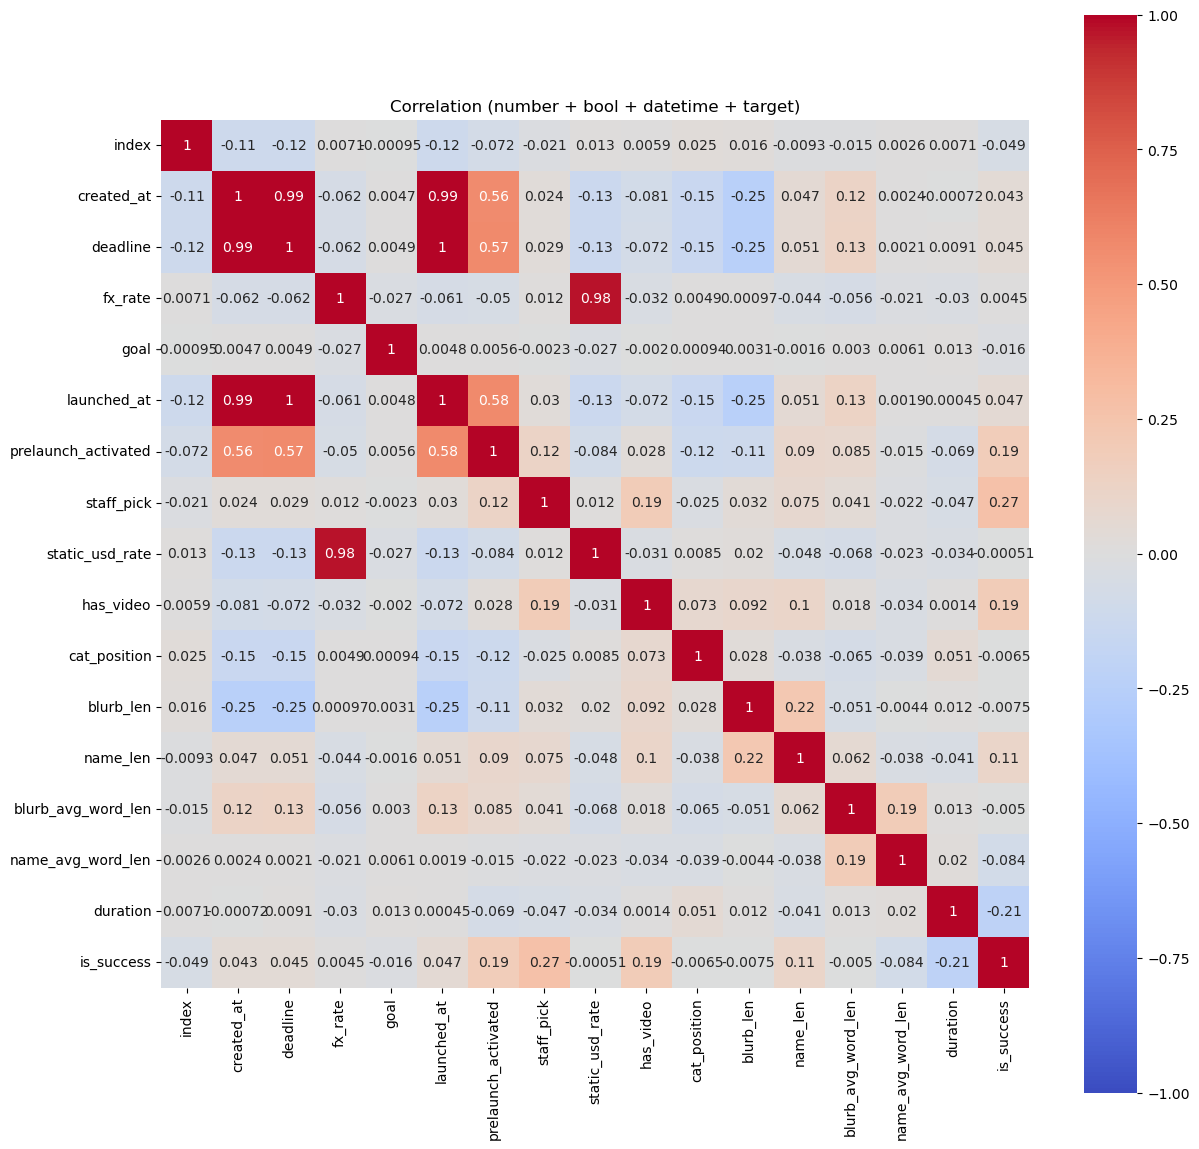

In [30]:
def plot_correlation_heatmap(df: pd.DataFrame):
    df = df.copy()
    df['is_success'] = df['state'] == 'successful'
    corr = df.select_dtypes(include=["number", "bool", "datetime"]).corr()

    plt.figure(figsize=(14, 14))
    ax = sns.heatmap(
        corr, 
        cmap="coolwarm", 
        vmin = -1, 
        vmax = 1,
        annot=True, 
        square = True,
    )
    ax.set_title("Correlation (number + bool + datetime + target)")
    
    plt.show()
plot_correlation_heatmap(kick_clean)

Most of our numeric (number, bool, datetime) features have very low correlation with success:
- Our highest correlation magnitude was with `staff_pick` at 0.27, which is still well away from anything especially substantial.
- ⭐`duration` has a mildly negative correlation, which might suggest that longer campaigns are actually less successful on average.
- Suprisingly, goal has no direct linear correlation with success rate. This is highly unintuitive, since it seems obvious that setting an extremely high goal arbitrarily should cause success rate to drop.
    - This may be due to the fact that goal is just simply too variant, with so many outliers the correlation may be thrown off.
    - Further analysis by category may be insightful.


The overall uninspiring linear correlation values suggests that nonlinear or interaction effects would be worth looking into. Meaning, we might want to lean toward tree-based models like Random Forest or XGBoost.

**Correlation Analyses: Category-Specific (TODO:🚧)**:

To try and investigate individual categories further, we will subset our dataset by parent category, and perform some light correlation analysis:

##### **Univariate Distributions**
Helping us reveal how individual features are distributed, to understand skewness and coverage of particularly important features.

In [92]:
def plot_goal_distributions(df):
    _, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes: list[plt.Axes] = axes.ravel()

    # Raw goal distribution
    sns.histplot(
        df["goal"],
        bins = 40,
        ax = axes[0],
        kde = True,
        edgecolor = None, 

    )
    axes[0].set_title("goal (raw)")

    # Log transformed goal
    goal_log = np.log(df["goal"])
    sns.histplot(
        goal_log, 
        bins = 40, 
        ax = axes[1],
        kde = True,
        edgecolor = None, 
    )
    axes[1].set_title("goal (log transformed)")
    axes[1].set_xlabel("ln(goal)")

    # Trimmed distribution (top 10% removed)
    g90 = df["goal"].quantile(0.90)
    goals_trim = df.loc[df["goal"] <= g90, "goal"]
    sns.histplot(
        goals_trim,
        bins = 40,
        ax = axes[2],
        kde = True,
        edgecolor = None, 
    )
    axes[2].set_title(r"goal ($\leq$ 90th percentile)")

    plt.suptitle("Goal distribution w/ transformations", fontsize = 14)
    plt.tight_layout()
    plt.show()

def plot_time_distributions(df):
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes: list[plt.Axes] = axes.ravel()

    year = df["launched_at"].dt.year
    sns.countplot(
        x = year, 
        ax = axes[0]
    )
    axes[0].set_title("Projects per Launch Year")
    axes[0].set_xlabel("launch year")
    axes[0].tick_params(axis="x", rotation=45)
    
    sns.histplot(
        df["duration"], 
        bins = 30, 
        ax = axes[1], 
        edgecolor = None, 
        kde = True
    )
    axes[1].set_title("Duration distribution")
    axes[1].set_xlabel("duration (days)")

    plt.suptitle("Time distributions", fontsize = 14)
    plt.tight_layout()
    plt.show()


def plot_category_distributions(df):
    _, axes = plt.subplots(3, 1, figsize=(12, 12))
    axes: list[plt.Axes] = axes.ravel()

    top_cats = df["cat_parent_name"].fillna("None").value_counts()
    sns.barplot(x=top_cats.values, y=top_cats.index, ax=axes[0])
    axes[0].set_title("Parent Categories by Frequency")
    axes[0].set_xlabel("count")
    axes[0].set_ylabel("")

    n = 15
    sub_cats_counts = df["cat_name"].fillna("None").value_counts()
    top_sub_cats = sub_cats_counts.head(n)
    sns.barplot(
        x = top_sub_cats.values, 
        y = top_sub_cats.index, 
        ax = axes[1]
    )
    axes[1].set_title(f"Top {n} Most Popular Subcategories")
    axes[1].set_xlabel("count")
    axes[1].set_ylabel("")

    sns.barplot(
        x = sub_cats_counts.values,
        y = sub_cats_counts.index,
        ax = axes[2]
    )
    axes[2].set_title("Full subcategory frequency distribution")
    axes[2].set_xlabel("count")
    axes[2].set_ylabel("")
    axes[2].set_yticks([])

    plt.tight_layout()
    plt.show()

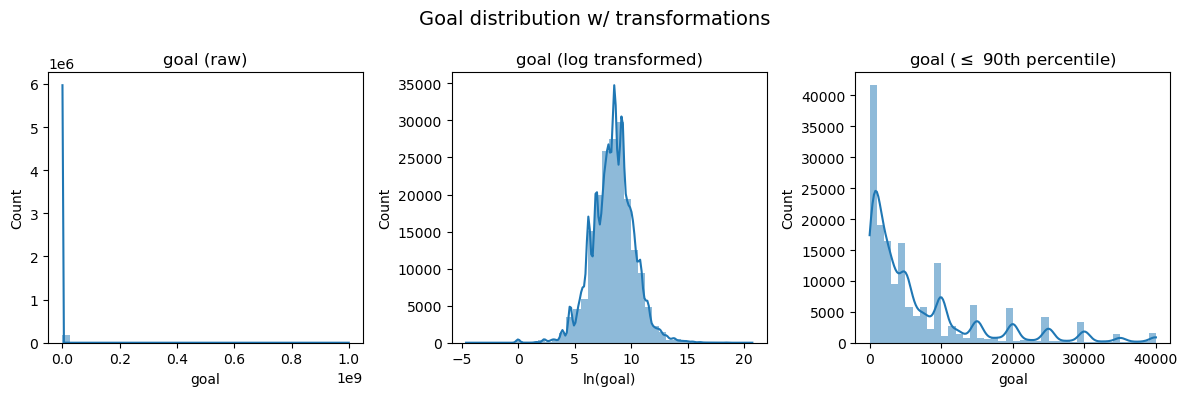

In [32]:
plot_goal_distributions(kick_clean)

The raw `goal` variable is heavily right-skewed.
- Log transforming `goal` seems to normalize it well. We can see a normal distribution emerge from the log transformed values.
- Trimnming down `goal` also seems to be useful. We keep the nature of the right-skew but also a new pattern seems to emerge:
    - We can see certain spikes in count for certain ranges of goal:
        - 10000, 15000, 20000, 25000, 30000, etc.
        - Evidently, human nature seems to draw some bias toward using round figures as the goal.

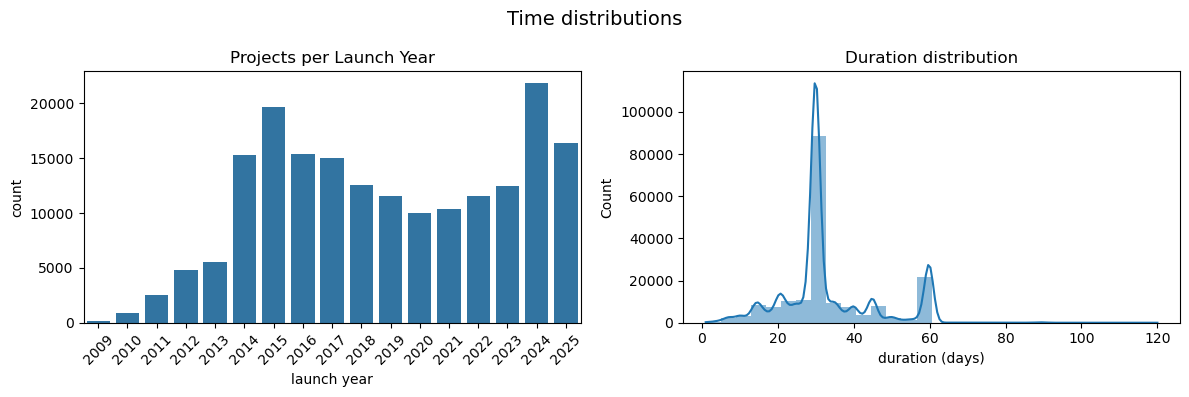

In [33]:
plot_time_distributions(kick_clean)



We have a good distribution of project count by year:
- Project count seemed to peak slightly in 2015 and 2024. Unsure of a reason why.

Duration clusters around 30 and 60 days.
- Evidently campainers like the round figures of 1 month, or 2 months to fund.

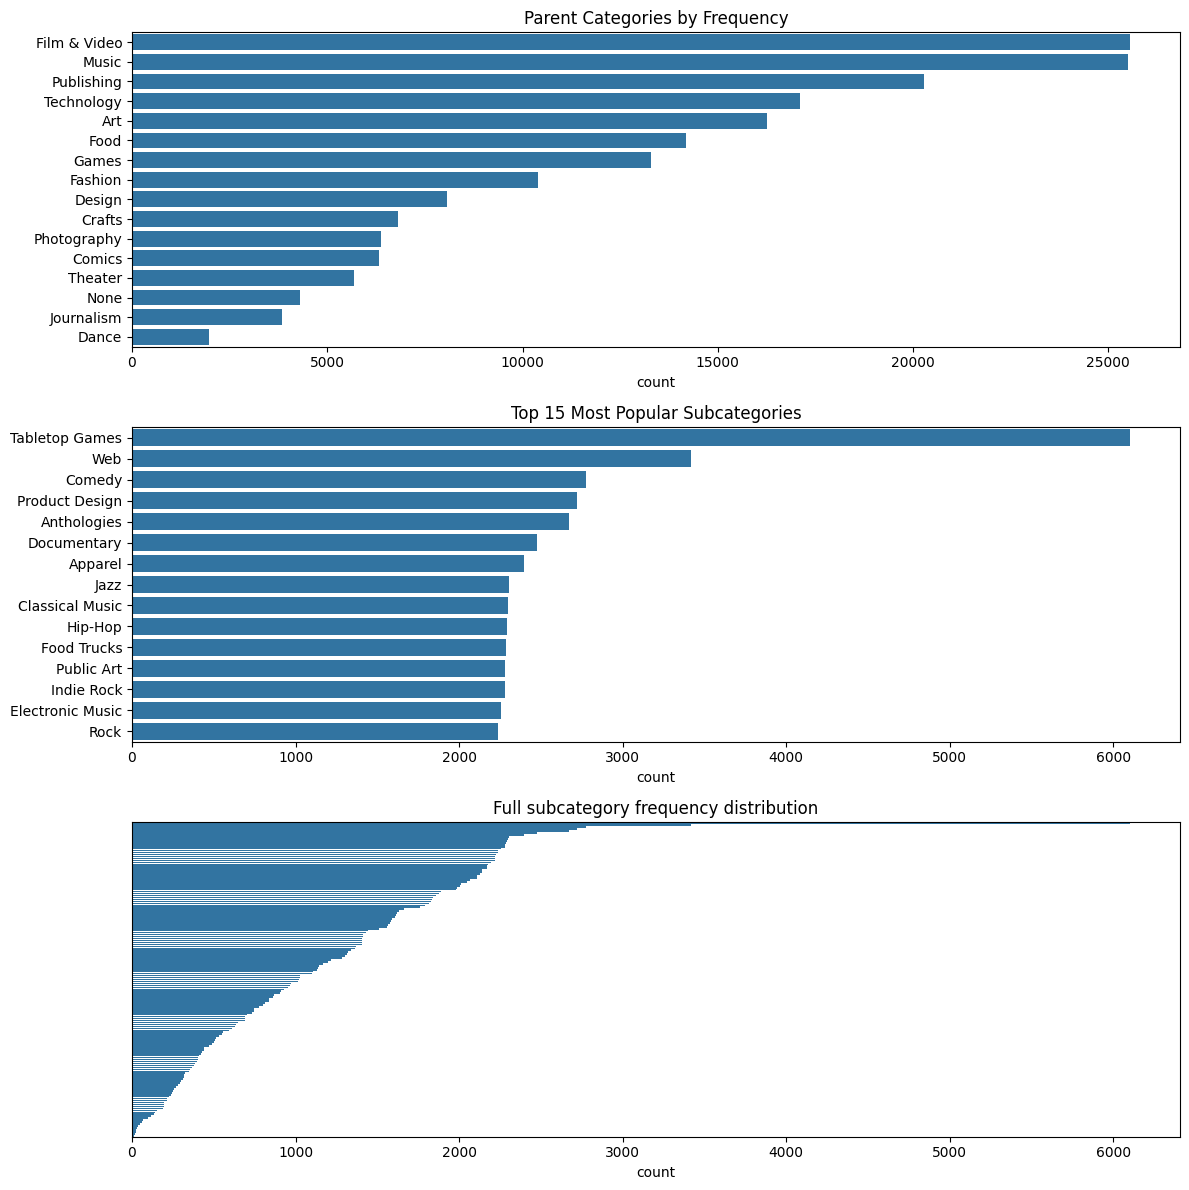

In [93]:
plot_category_distributions(kick_clean)

The dataset is highly imbalanced by category, both parent and subcategory:
- "Film & Video", "Music" and "Publishing" are the heavy favorites
- The rest slowly peter down, with "Dance" as the least popular with less than 2500 total projects.
- Evidently, some of the categories are much more niche than others.

There may be a strong implication from this observation:
- For general models, dominant categories will heavily influence learned patterns. This directly ties into our question, can category-specific models be justified to correct this imbalance?

##### **Bivariate Distributions**

🚧 We are planning on further on these visualizations for the final report, this section is a work in progress 🚧

Drawing a pairplot, casting a net to see if we can find any obvious nonlinear or linear relations visually that may warrent further investigation:
- Caveat: To draw a pairplot, we take a subsample of 1000 samples, since the entire dataset would be too computationally difficult to draw with.

In [29]:
kick_clean = load_processed_data(use_relative = True)

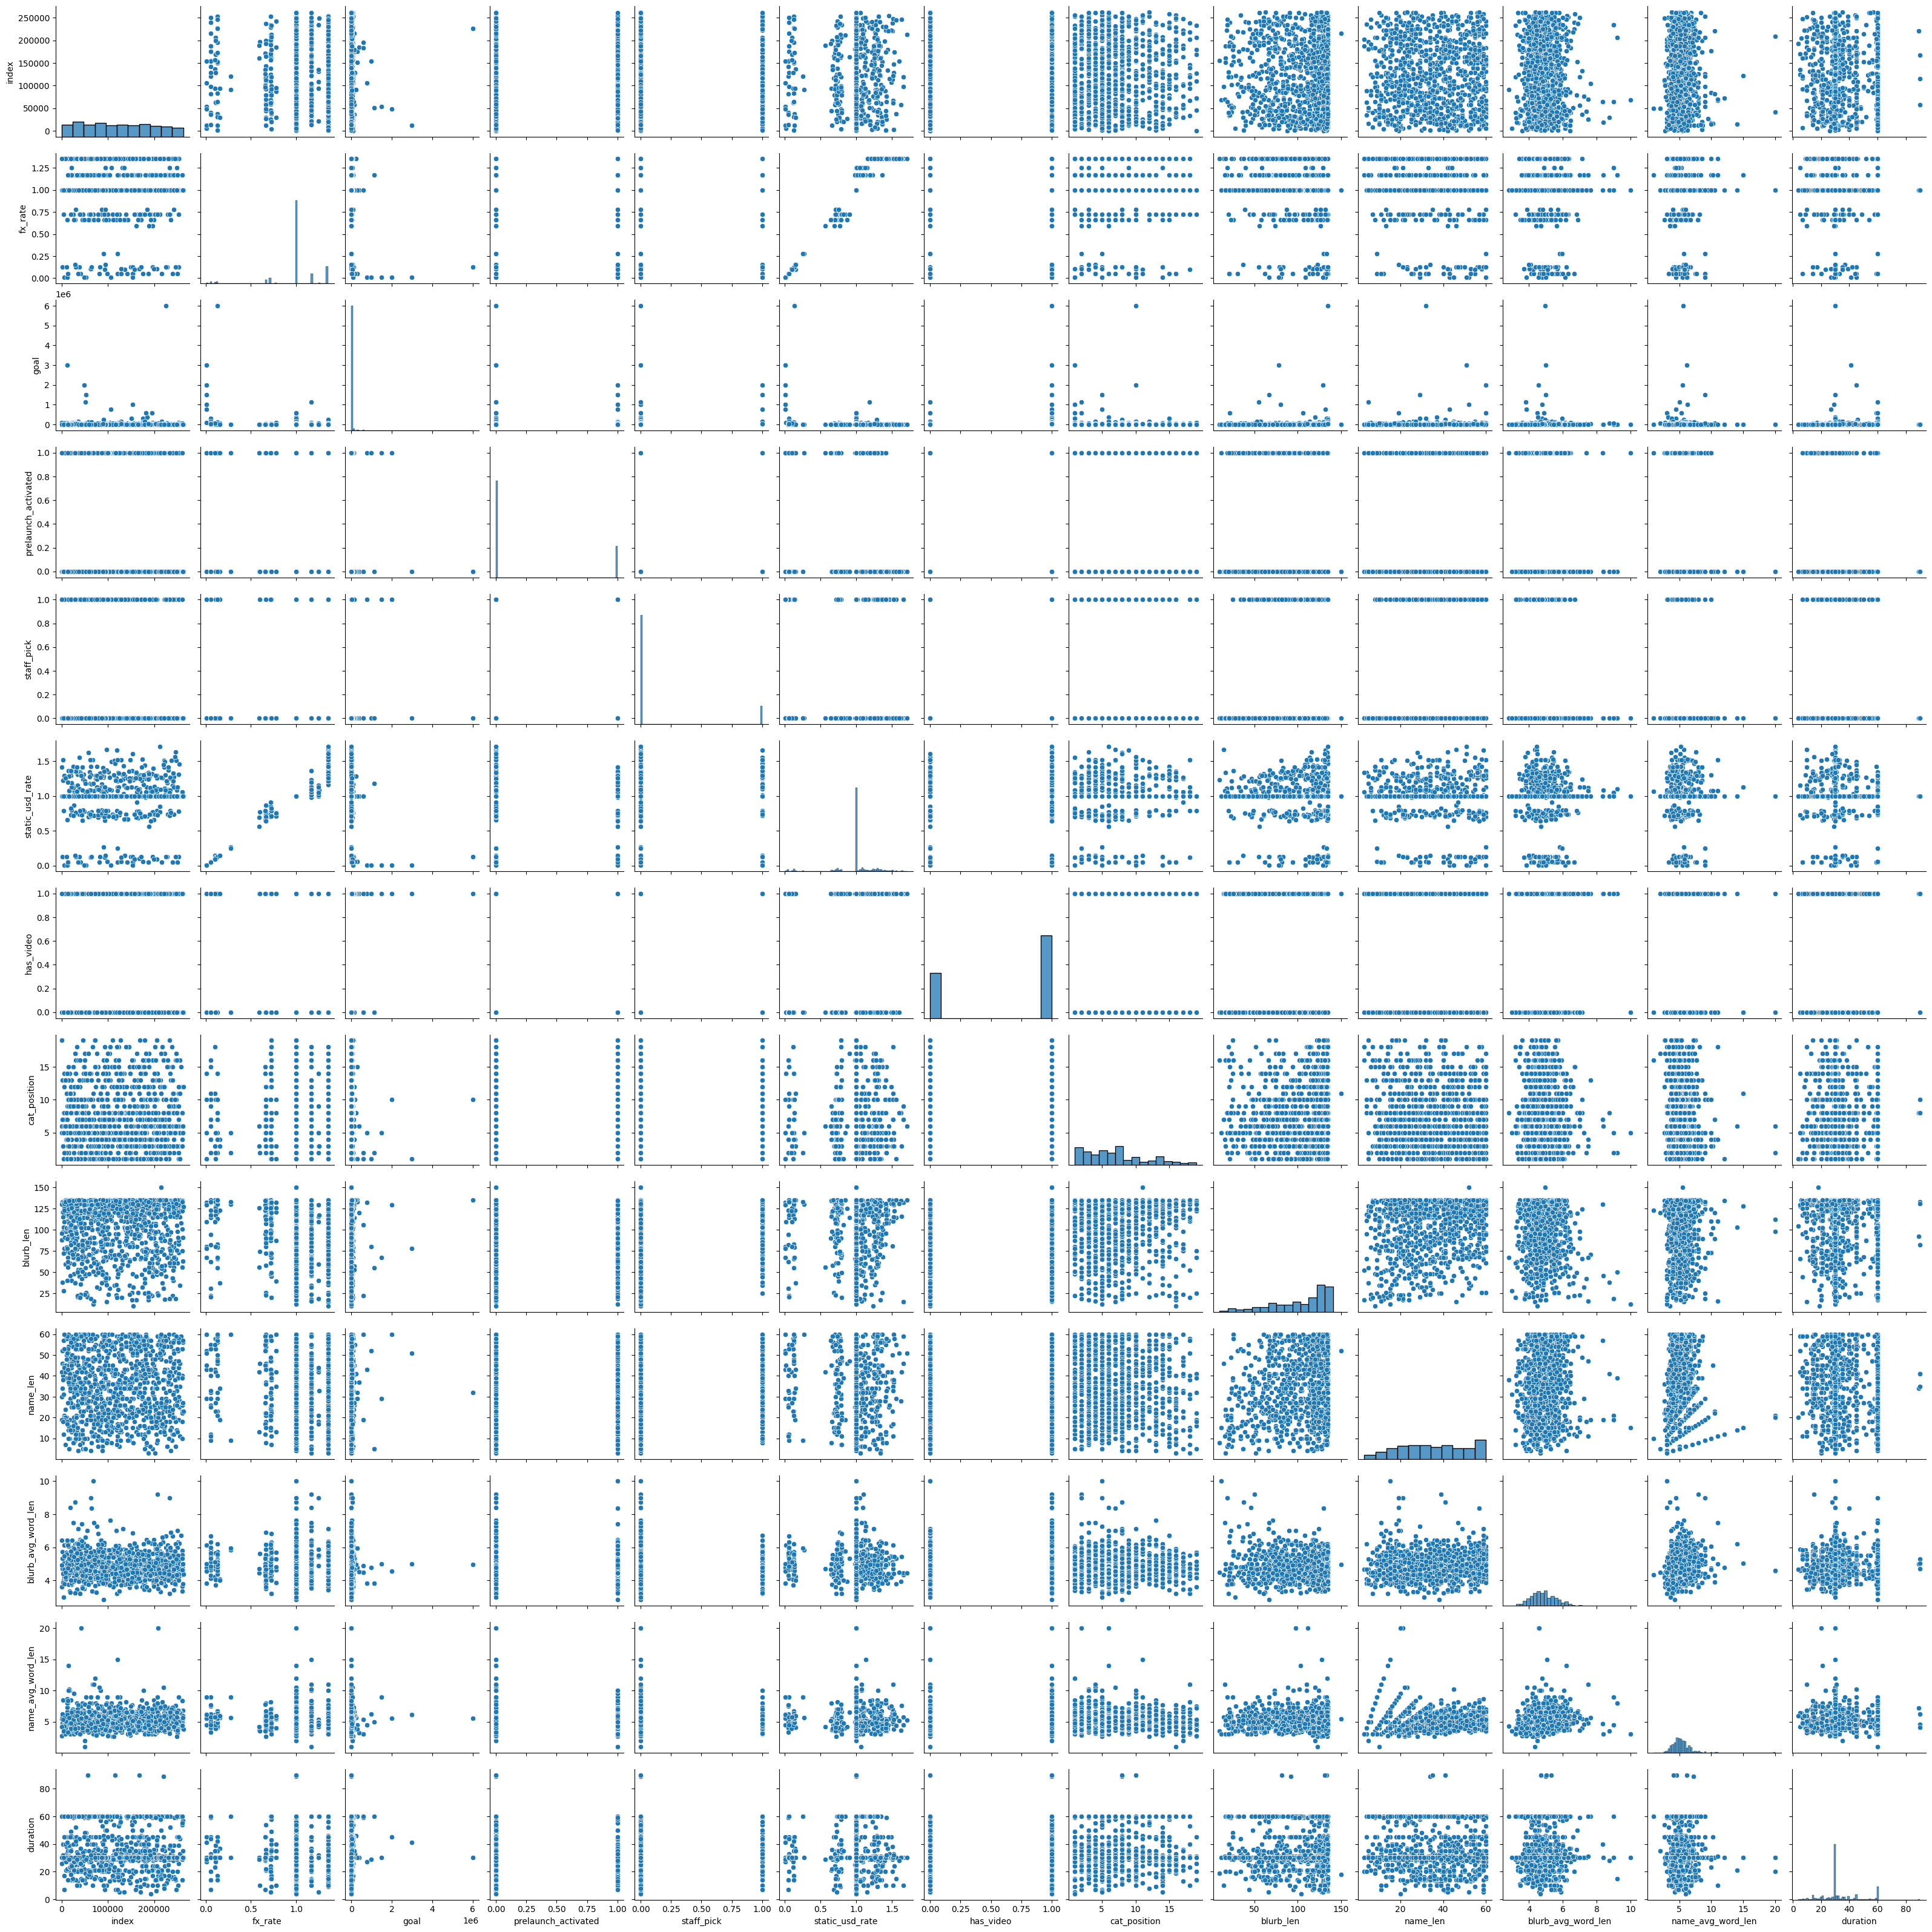

In [ ]:
kick_sample_1k = kick_clean.select_dtypes(include = ['number', 'bool', 'datetime']).sample(1000)
kick_sample_1k.drop(columns = ['index'])
sns.pairplot(kick_sample_1k)

Drawing more specific bivariate analyses

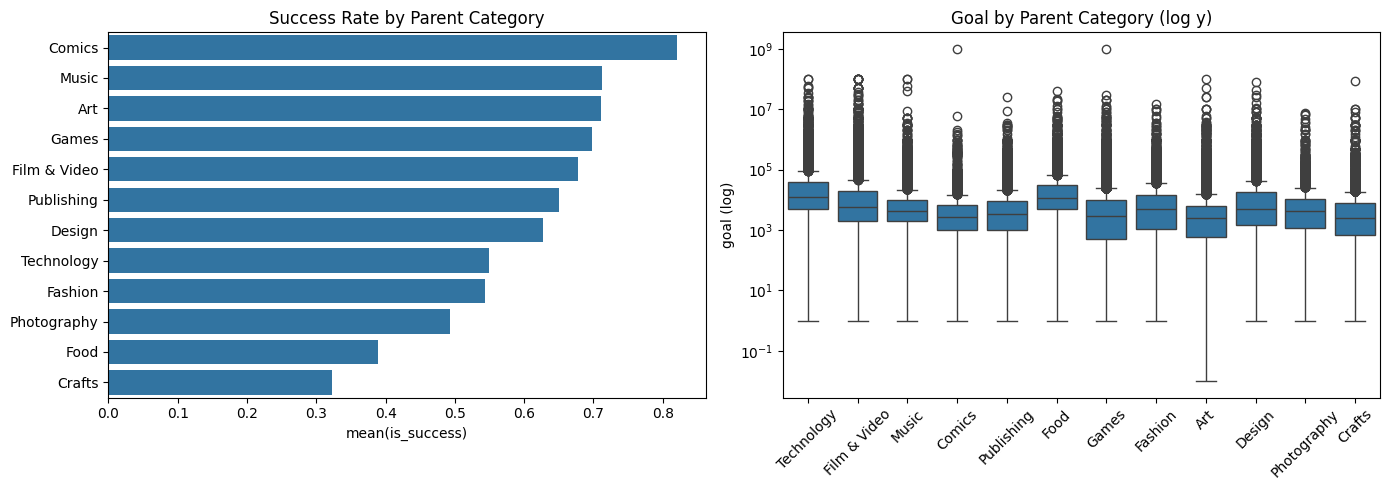

In [89]:
def plot_category_vs(df2):
    _, axes = plt.subplots(1, 2, figsize=(14, 5))
    df = df2.copy()
    df['is_success'] = df['state'] == 'successful'
    
    counts = df["cat_parent_name"].value_counts()
    top12 = counts.index[:12]
    tmp = df[df["cat_parent_name"].isin(top12)]
    rate = tmp.groupby("cat_parent_name")["is_success"].mean().sort_values(ascending=False)
    sns.barplot(x=rate.values, y=rate.index, ax=axes[0])
    axes[0].set_title("Success Rate by Parent Category")
    axes[0].set_xlabel("mean(is_success)")
    axes[0].set_ylabel("")

    # Log-scale on y by using set_yscale after plotting
    tmp = df[df["cat_parent_name"].isin(top12)] if "top12" in locals() else df
    sns.boxplot(data=tmp, x="cat_parent_name", y="goal", ax=axes[1])
    axes[1].set_yscale("log")
    axes[1].set_title("Goal by Parent Category (log y)")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("goal (log)")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()
plot_category_vs(kick_clean)

For the Goal by Parent Category graph:
- Goal seems to vary slightly across categories
- Combined with the fact that it is so nonlinearly tied to success (from correlation analysis), this may suggest taht a global model (trained on all data) may miss some specific category effects.

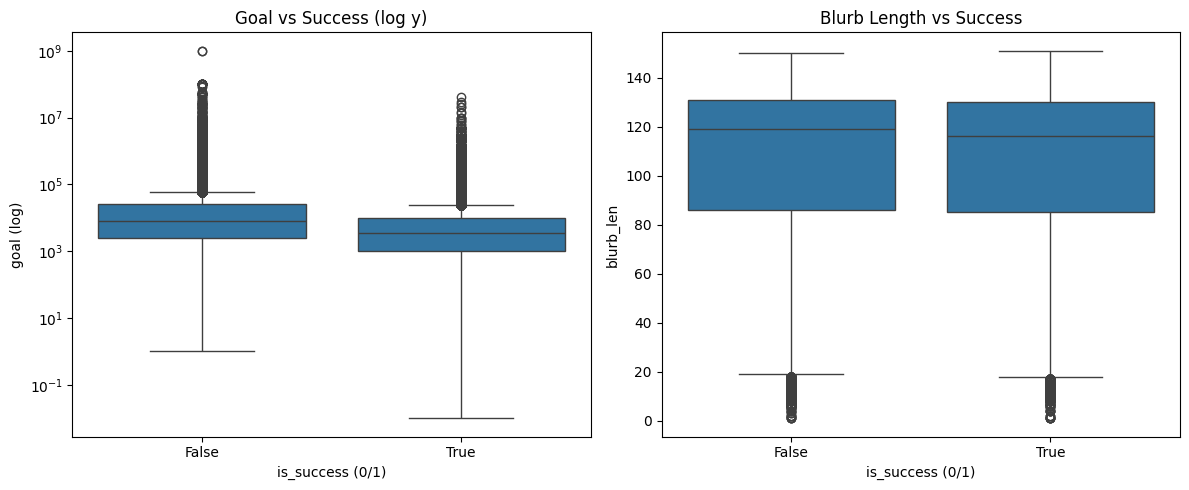

In [90]:
def plot_goal_vs_success(df2):
    _, axes = plt.subplots(1, 2, figsize=(12, 5))

    df = df2.copy()
    df['is_success'] = df['state'] == 'successful'

    # Boxplot by success (log-scale y)
    sns.boxplot(data=df, x="is_success", y="goal", ax=axes[0])
    axes[0].set_yscale("log")
    axes[0].set_title("Goal vs Success (log y)")
    axes[0].set_xlabel("is_success (0/1)")
    axes[0].set_ylabel("goal (log)")

    sns.boxplot(data=df, x="is_success", y="blurb_len", ax=axes[1])
    axes[1].set_title("Blurb Length vs Success")
    axes[1].set_xlabel("is_success (0/1)")
    axes[1].set_ylabel("blurb_len")

    plt.tight_layout()
    plt.show()
plot_goal_vs_success(kick_clean)

For "Goal vs. Success": 
- Even after log transform, successful projects have lower median goals.
- Its still interesting to see that extremely high goals are necessarily guaranteed to fail.

For "Blurb Length vs. Success":
- We can see that extracted text information is not very great as a predictor in aggregate. Blurbs have a cutoff, the lack of variation may be one fault.

Further analysis of goal's relation to success is warrented still. Its impact magnitude likely differs across categories.

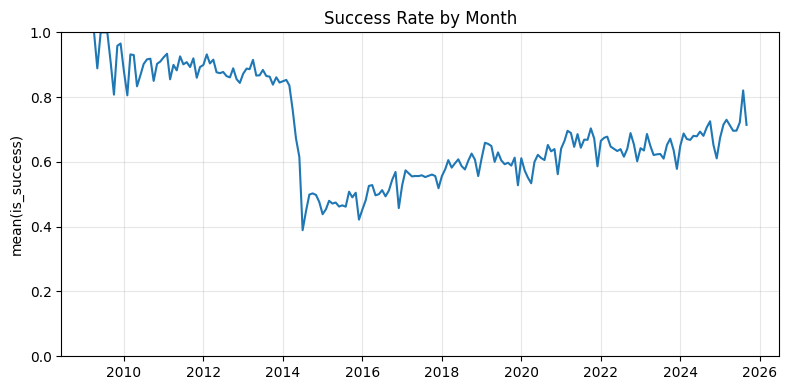

In [ ]:
def plot_success_vs_time(df2):
    df = df2.copy()
    df['is_success'] = (df['state'] == 'successful')

    # Ensure datetime
    df['launched_at'] = pd.to_datetime(df['launched_at'], errors='coerce')

    # Index by launch date and compute monthly success rate
    ts = df.dropna(subset=['launched_at']).set_index('launched_at').sort_index()
    monthly = (
        ts['is_success']
        .resample('MS')
        .mean()
        .rename('success_rate')
        .reset_index()
    )

    # Plot with seaborn
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.lineplot(data=monthly, x='launched_at', y='success_rate', ax=ax)
    ax.set_title('Success Rate by Month')
    ax.set_xlabel('')
    ax.set_ylabel('mean(is_success)')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_success_vs_time(kick_clean)

There’s a sharp drop in success rate around 2014–2015 from around 80% down all the way to 40%. This is then followed by a gradual recovery back up to around 60-70%.
- It is clear that temporal effects can play a key effect for our models.
- We have already engineered features to include an age of project signal. ⭐We might have greater success with our models if we cutoff projects dating from before the dip, to better signal our models to capture the very linear trend up from that time.

<!-- We want to perform the following visualizations:


1. Correlation heatmap:
    - Answering: Do certain features like ... have ...
    - We would like to additionally check correlation some non-numeric features, our target and some specific other features like `staff_pick` and `has_video`.
    - This will require encoding non-numeric variables to numeric.

2. Univariate distributions:
    - Answering: ...
        - For example, are most of our projects very recent, or very old?

3. Bivariate distributions:
    - category features against `state` would help us answer:
        - Do certain categories tend to have a higher success rate?
    - category features against `goal` would help us answer:
        - Do certain categories tend to have a higher or lower goal?
    - `launched_at` against `state` would us answer: ...


- Visualizations of feature distributions:
    - `goal` distribution, using log transformation to control skew
    - `launched_at` to investigate the distribution of projects in our dataset. This can weigh in our analysis, in terms of recency bias / historical bias.
- Checking cross correlation values:
    - Possible linear relationships between goal size and things like `created_at` or `deadline`. Perhaps longer funding duration would mean also a larger goal.
- Checking correlations with our target:
    - Do longer blurbs lead to more successful projects? Does a smaller goal tend to lead to higher success rate?
- Visualizations of category against the target `state`, as well as other features.
    - Do certain categories tend to have higher success rates?
    - Do certain categories tend to have higher or lower goals?
- Visualization of regional trends.
    - Do certain regions have a preference to specific creative categories?

- Checking correlation values with `staff_pick`, `has_video` against our target `state` and checking whether correlation might change based on category. Answering "is it more important to have a video for `x` campaigns in category"? -->

# MODELING

1. [Machine Ready Preprocessing](#machine-ready-preprocessing)
2. [Train-Test Split](#train-test-split)
3. [Baseline](#1-naive-baseline-majority-class-model)
4. [Random Forest](#2-random-forest-model)
5. [Results and Interpretation](#modeling-results)

### Machine Ready Preprocessing

For our EDA step, our preprocessing was mainly to service human insight. We kept the raw values and relations as intact as possible. Now for our modeling step, we need to get the data machine ready:
- Doing a final drop of irrelevant features.
    - `index` is useful as a "lookup" number, incase particular data points are interesting and we want to reference the original unaltered point from the original. Not relevant for modeling.
    - `name` and `blurb`, also interesting for human insight, but not relevant anymore (we are not using text directly).
- Encoding categorical variables
    - Target `state` to boolean `is_successful`
    - Features like `cat_name`, `loc_name`, `country`, etc.
- Standardizing / scaling numerical variables
- Converting or dropping datetime features
    - We are not planning on doing time series like prediction for our modeling. We will instead convert the datetime feature `launched_at` to `project_age`, and drop the other two (highly similar) `created_at` and `deadline`.

For a tree based model, we don't actually caree about standardizing our numerical features, since they use thresholds for splitting. Standardization does not change ordering, and thus would not change how thresholds are picked.
- In addition, for many tree based models, they are able to handle categorical variables by default.

In [51]:
def drop_final_irrelevant_columns_and_encode_target(df: pd.DataFrame) -> pd.DataFrame:
    # These are useful for lookup / human insight, but not for machine learning
    df = df.copy()
    irrelevant_columns = [
        "index",
        "name",
        "blurb",
    ]
    df = df.drop(columns=irrelevant_columns)

    # Encode target
    df["is_successful"] = df["state"] == "successful"
    df = df.drop(columns=["state"])
    return df

def handle_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    datetime_columns = [
        "created_at",
        "deadline",
        "launched_at"
    ]

    df["age_days"] = (pd.Timestamp.now() - df["launched_at"]).dt.days

    df = df.drop(columns = datetime_columns)
    return df

def machine_ready_preprocessing(
    df: pd.DataFrame, testing=False, cat_encoders = {}, num_scaler=None
) -> tuple[pd.DataFrame, LabelEncoder, StandardScaler]:
    df = handle_datetime_features(df)
    df = drop_final_irrelevant_columns_and_encode_target(df)
    # Training set will fit the encoders / scalers, the test set will use the fitted encoders / scalers
    categorical_cols = df.select_dtypes(include=["object"]).columns
    numerical_cols = df.select_dtypes(include=["number"]).columns
    if not testing:
        # Encode categorical features
        for cat_col in categorical_cols:
            cat_encoder = LabelEncoder()
            cat_encoder.fit(df[cat_col].astype(str))
            cat_encoders[cat_col] = cat_encoder

        # Standardize numerical features
        num_scaler = StandardScaler()
        num_scaler.fit(df[numerical_cols])

    
    for cat_col in categorical_cols:
        df[cat_col] = cat_encoders[cat_col].transform(df[cat_col].astype(str))

    df[numerical_cols] = num_scaler.transform(df[numerical_cols])
    return df, cat_encoders, num_scaler

In [52]:
kick_transformed, cat_encoders, num_scaler = machine_ready_preprocessing(kick_clean)

In [53]:
kick_transformed.head()

,country,currency,fx_rate,goal,prelaunch_activated,staff_pick,static_usd_rate,usd_type,loc_name,loc_state,...,cat_name,cat_position,cat_parent_name,blurb_len,name_len,blurb_avg_word_len,name_avg_word_len,duration,age_days,is_successful
0,9,5,1.397361,-0.014266,False,False,1.947103,0,6834,312,...,92,-0.471232,15,0.835749,-1.236658,0.671645,1.145912,-0.240003,1.015139,True
1,24,14,0.049263,0.170737,False,False,0.056492,0,6551,607,...,132,0.829195,14,-1.875923,-1.557711,2.194664,3.920130,-0.083141,-1.179677,False
2,9,5,1.397361,-0.011375,False,False,1.978428,0,6834,312,...,122,-1.121445,3,0.357219,-0.209289,-1.498655,-0.241198,-0.240003,1.063087,False
3,24,14,0.049263,-0.016457,False,False,0.056492,0,10437,324,...,5,-1.121445,6,0.867651,-0.658763,-0.997817,-0.067809,-0.240003,-0.513128,True
4,24,14,0.049263,-0.016434,False,False,0.056492,0,6892,147,...,109,1.479408,10,-1.269784,0.111764,-0.107171,-0.010013,-0.632158,1.597271,True


### Train-Test Split

To make comparisons fair between models, we will set a train - test split to be used for all models:

In [ ]:
def perform_train_test_split(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X = df.drop(columns = ['is_successful'])
    y = df['is_successful']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = perform_train_test_split(kick_transformed)

### 1. Naive baseline (majority class model)
- Predict everything as the majority class

In [76]:
def model_naive_baseline(X_train, X_test, y_train, y_test):
    majority_class = y_train.value_counts().sort_values(ascending = False).keys()[0]
    predictions = np.full_like(y_test, majority_class)

    accuracy = (predictions == y_test).mean()

    print(f"Majority class baseline model accuracy: {accuracy * 100:.2f}%")
    return accuracy
naive_baseline_acc = model_naive_baseline(X_train, X_test, y_train, y_test)

Majority class baseline model accuracy: 62.13%


### 2. Random Forest Model

For our first model, we will utilize the Random Forest Classifier model. First training a general model on all categories.
- Can handle categorical features natively
- Can handle unstandardized data natively as well

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def model_general_rf(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    accuracy = (predictions == y_test).mean()
    print(f"Random Forest model accuracy: {accuracy * 100:.2f}%")
    return accuracy
general_rf_acc = model_general_rf(X_train, X_test, y_train, y_test)

Random Forest model accuracy: 81.59%


Then, we will compare this against category specific models. 
- We will train Random Forest models trained on data from each specific category
- We will then "ensemble the models". We will use the category of a test value to decide which model to use in prediction, then take a weighted average in prediction accuracy.

In [77]:
def model_category_specific_rf(X_train, X_test, y_train, y_test):
    rf_models = {} # trained model per category
    accuracies = {} # model accuracy per category

    cat_name_encoder = cat_encoders["cat_parent_name"]
    for cat_val, X_train_group in X_train.groupby("cat_parent_name"):
        # find matching rows in train and test for this category
        train_idx = X_train_group.index
        test_idx  = X_test[X_test["cat_parent_name"] == cat_val].index

        # pull the feature matrices without the category column itself
        X_train_cat = X_train.loc[train_idx].drop(columns=["cat_parent_name"])
        X_test_cat  = X_test.loc[test_idx].drop(columns=["cat_parent_name"])

        # pull the targets for just those rows
        y_train_cat = y_train.loc[train_idx]
        y_test_cat  = y_test.loc[test_idx]

        # skip if we don't have test data for this category
        if len(test_idx) == 0 or len(train_idx) == 0:
            continue

        # train model for this category
        rf = RandomForestClassifier()
        rf.fit(X_train_cat, y_train_cat)

        # evaluate and store
        y_pred = rf.predict(X_test_cat)
        accuracy = (y_pred == y_test_cat).mean()

        rf_models[cat_val] = rf
        accuracies[cat_val] = accuracy

        # pulling the name off the encoder
        cat_parent_name = cat_name_encoder.inverse_transform([cat_val])[0]
        print(f"{cat_parent_name}: accuracy = {accuracy * 100:.2f}%")

    return rf_models, accuracies
rf_models, accuracies = model_category_specific_rf(X_train, X_test, y_train, y_test)

Art: accuracy = 81.23%
Comics: accuracy = 87.49%
Crafts: accuracy = 77.96%
Dance: accuracy = 70.61%
Design: accuracy = 80.65%
Fashion: accuracy = 83.15%
Film & Video: accuracy = 85.29%
Food: accuracy = 82.26%
Games: accuracy = 88.30%
Journalism: accuracy = 82.07%
Music: accuracy = 84.34%
None: accuracy = 95.56%
Photography: accuracy = 79.58%
Publishing: accuracy = 81.01%
Technology: accuracy = 84.31%
Theater: accuracy = 72.38%


In [83]:
def weighted_accuracy_of_category_specific_rf(rf_models):
    all_preds = []
    all_trues = []

    for cat_val, rf in rf_models.items():
        test_idx = X_test[X_test["cat_parent_name"] == cat_val].index
        X_test_cat = X_test.loc[test_idx].drop(columns=["cat_parent_name"])
        y_test_cat = y_test.loc[test_idx]

        y_pred_cat = rf.predict(X_test_cat)

        all_preds.append(y_pred_cat)
        all_trues.append(y_test_cat)

    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)
    weighted_acc = (all_preds == all_trues).mean()
    print(f"Overall (weighted) accuracy: {weighted_acc * 100:.2f}%")
    return weighted_acc
cat_weighted_rf_model_accuracy = weighted_accuracy_of_category_specific_rf(rf_models)

Overall (weighted) accuracy: 83.13%


### Modeling Results:

- Majority Class: accuracy = 62.13%
- Random Forest (General): accuracy = 81.59%
- Random Forests (Category Specific Ensemble): accuracy = 83.13%
    - Art: accuracy = 81.23%
    - Comics: accuracy = 87.49%
    - Crafts: accuracy = 77.96%
    - Dance: accuracy = 70.61%
    - Design: accuracy = 80.65%
    - Fashion: accuracy = 83.15%
    - Film & Video: accuracy = 85.29%
    - Food: accuracy = 82.26%
    - Games: accuracy = 88.30%
    - Journalism: accuracy = 82.07%
    - Music: accuracy = 84.34%
    - None: accuracy = 95.56%
    - Photography: accuracy = 79.58%
    - Publishing: accuracy = 81.01%
    - Technology: accuracy = 84.31%
    - Theater: accuracy = 72.38%

Our baseline had an accuracy of 62.13%, which means that roughly 62% of all kickstarter projects over the years have been successful. We should weigh this into account when interpreting the scale of our other results.

Our random forest models performed significantly better than our baseline, which means our models must be meaningfully predictive rather than just capturing the baseline.

### Interpretations

Restating my research question once more:

>Are interpretable Kickstarter success prediction models equally accurate across categories? And furthermore, are models trained within specific categories more predictive within their category than models that are trained generally?

The general model trained across all categories performance serves as the benchmark for the comparison with the category specific modeling.

Looking at specific categories, we can see a very noticable range in accuracy:
- Some specific category models were significantly higher in accuracy than the general model, we had a max accuracy of 95.56% for the "None" category.
- Some specific category models were significantly lower in accuracy than the general model, we had a lowest accuracy of 70.61% for the "Dance" category
    - ⭐This suggests that predictive accuracy is not uniform across categories. Some categories clearly have more learnable success patterns.

The overall ensemble weighted accuracy shows slight improvement over the general model (+ 1.54%). 
- ⭐This suggests that category specialization can provide a small but real predictive gain when models are specifically tailored to projec type!